In [15]:
import pandas as pd
import numpy as np
import os
from env import get_db_url
from pathlib import Path 
import csv
import wrangle as w
from scipy import stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

In [3]:
# creating train, validate and test datasets
train, validate, test = w.wrangle_zillow()

In [4]:
#size of train dataset
train.shape

(784184, 7)

In [5]:
#size of train validate dataset
validate.shape

(336079, 7)

In [6]:
#size of Test dataset
test.shape

(280066, 7)

In [10]:
#Null count in train dataset
train.isnull().sum()

bedrooms          0
bathrooms         0
area              0
year_built        0
property_value    0
taxamount         0
fips              0
dtype: int64

In [11]:
#Null count in validate dataset
validate.isnull().sum()

bedrooms          0
bathrooms         0
area              0
year_built        0
property_value    0
taxamount         0
fips              0
dtype: int64

In [12]:
#Null count in test dataset
test.isnull().sum()

bedrooms          0
bathrooms         0
area              0
year_built        0
property_value    0
taxamount         0
fips              0
dtype: int64

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280066 entries, 1375137 to 51867
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bedrooms        280066 non-null  float64
 1   bathrooms       280066 non-null  float64
 2   area            280066 non-null  float64
 3   year_built      280066 non-null  float64
 4   property_value  280066 non-null  float64
 5   taxamount       280066 non-null  float64
 6   fips            280066 non-null  float64
dtypes: float64(7)
memory usage: 17.1 MB


In [18]:
# columns used as independent variables 
x_cols = ['taxamount','area']

In [20]:
# assigning values to x/y train, validate and test 
X_train = train[x_cols]
y_train = train['property_value']

X_validate = validate[x_cols]
y_validate = validate['property_value']

X_test = test[x_cols]
y_test = test['property_value']


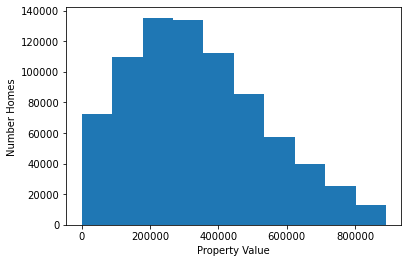

In [21]:
# Visualizing target variable "Property Value"
plt.hist(y_train)
plt.xlabel("Property Value")
plt.ylabel("Number Homes")
plt.show()


## Baseline 

In [22]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict property_value_pred_mean
prop_value_pred_mean = y_train['property_value'].mean()
y_train['prop_value_pred_mean'] = prop_value_pred_mean
y_validate['prop_value_pred_mean'] = prop_value_pred_mean

# 2. compute prop_value_pred_median
prop_value_pred_median = y_train['property_value'].median()
y_train['prop_value_pred_median'] = prop_value_pred_median
y_validate['prop_value_pred_median'] = prop_value_pred_median

# 3. RMSE of prop_value_pred_mean
rmse_train = mean_squared_error(y_train.property_value, y_train.prop_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.prop_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of prop_value_pred_median
rmse_train = mean_squared_error(y_train.property_value, y_train.prop_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.prop_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  194778.78 
Validate/Out-of-Sample:  194882.89
RMSE using Median
Train/In-Sample:  196446.47 
Validate/Out-of-Sample:  196617.16


## Visualizing target variable 

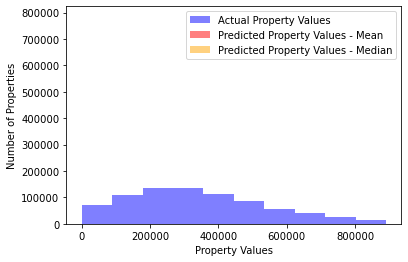

In [28]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.property_value, color='blue', alpha=.5, label="Actual Property Values")
plt.hist(y_train.prop_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=20, label="Predicted Property Values - Mean")
plt.hist(y_train.prop_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=20, label="Predicted Property Values - Median")
plt.xlabel("Property Values")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


## LinearRegression OLS

In [32]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lm)**(1/2)

# predict validate
y_validate['property_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  49215.327855129166 
Validation/Out-of-Sample:  49782.08650226038


## LassoLars

In [33]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lars)**(1/2)

# predict validate
y_validate['property_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  49227.14386403 
Validation/Out-of-Sample:  49794.818234966595


## TweedieRegressor(GLM)

In [35]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_glm)**(1/2)

# predict validate
y_validate['property_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  194778.78465735377 
Validation/Out-of-Sample:  194882.8855410119


## Polynomial regression

In [36]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


## Linear Regression 

In [37]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.property_value)

# predict train
y_train['property_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lm2)**(1/2)

# predict validate
y_validate['property_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  49171.6831429958 
Validation/Out-of-Sample:  49747.63933240868
